In [88]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def std_npe(row):
    return np.std(row.to_numpy())

def range_detections(row):
    rownp = row.to_numpy()
    return np.nonzero(rownp)[0][-1] - np.nonzero(rownp)[0][0] + 1

def spatial_var(row):
    rownp = row.to_numpy()
    return np.var(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))

def spatial_std(row):
    rownp = row.to_numpy()
    return np.std(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))

def compute_features(row):
    rownp = row.to_numpy()
    return [np.sum(rownp),                        # NPE
            np.nonzero(rownp)[0].shape[0],        # NActiveSlices
            np.mean(rownp),                       # Mean NPE
            np.std(rownp),                        # Std NPE
            np.nonzero(rownp)[0][-1] - np.nonzero(rownp)[0][0] + 1,    # Range
            np.var(np.repeat(np.argwhere(rownp>0), rownp[rownp>0])),   # Var
            np.std(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))]   # Var   


In [11]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [20]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Ar39", "SnapshotAr39")
fileinprefix = "SnapshotAr39*.csv"

df_ar39 = load_dataframe_from_files(dirin, fileinprefix, max_files=30)
df_ar39 = df_ar39[df_ar39.pedetected>0]
df_ar39 = df_ar39[df_ar39.columns[:-1]]

[Info] Loading 100 files wt prefix:
SnapshotAr39*.csv
.............................


In [4]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Muons", "SnapshotMuons")
fileinprefix = "SnapshotMuons*.csv"

df_mu = load_dataframe_from_files(dirin, fileinprefix, max_files=100)
df_mu = df_mu[df_mu.pedetected>0]
df_mu = df_mu[df_mu.columns[:-1]]

[Info] Loading 100 files wt prefix:
SnapshotMuons*.csv
...................................................................................................


## Select data

In [22]:
df_mu["NActiveSlices"] = df_mu.iloc[:, 3:3+n_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39["NActiveSlices"] = df_ar39.iloc[:, 3:3+n_slices].apply(lambda row: nr_active_slices(row), axis=1)

In [51]:
print("Cut on NActiveSlices>=8:")
print("Eff: {}".format(len(df_mu[(df_mu.NActiveSlices>=8)])/len(df_mu)))
print("FPR: {}".format(len(df_ar39[(df_ar39.NActiveSlices>=8)])/len(df_ar39)))
print()

print("Cut on NPE>=11")
print("Eff: {}".format(len(df_mu[(df_mu.pedetected>=11)])/len(df_mu)))
print("FPR: {}".format(len(df_ar39[(df_ar39.pedetected>=11)])/len(df_ar39)))
print()

print("Cut on NPE>=11 & NAS>=8")
print("Eff: {}".format(len(df_mu[(df_mu.pedetected>=11) & (df_mu.NActiveSlices>=8)])/len(df_mu)))
print("FPR: {}".format(len(df_ar39[(df_ar39.pedetected>=11) & (df_ar39.NActiveSlices>=8)])/len(df_ar39)))
print()

Cut on NActiveSlices>=8:
Eff: 0.8004342810612743
FPR: 0.055751584506205154

Cut on NPE>=11
Eff: 0.7915450905883151
FPR: 0.052481930791537255

Cut on NPE>=11 & NAS>=8
Eff: 0.7900522494401846
FPR: 0.0427744034031025



In [53]:
maxPEar39 = df_ar39.pedetected.max()
df_lemu = df_mu[df_mu.pedetected <= maxPEar39]
print("[Info] Loaded {} Ar39 decays, with maximum {} PE detected".format(len(df_ar39), maxPEar39))
print("[Info] Selected {} Muons, with maximum {} PE detected".format(len(df_lemu), df_lemu.pedetected.max()))

[Info] Loaded 1892861 Ar39 decays, with maximum 53 PE detected
[Info] Selected 4505 Muons, with maximum 53 PE detected


## Remove Test Data for later evaluation

In [56]:
# Remove test data for later eval
n_train_mu, n_train_ar = 505, 1000000
muons_test, muons_train = df_lemu.iloc[:n_train_mu, :], df_lemu.iloc[n_train_mu:, :]
ar39_test, ar39_train = df_ar39.iloc[:n_train_ar, :], df_ar39.iloc[n_train_ar:, :]
print("[Info] Muon Train {}, Test {}".format(len(muons_train), len(muons_test)))
print("[Info] Ar39 Train {}, Test {}".format(len(ar39_train), len(ar39_test)))

[Info] Muon Train 4000, Test 505
[Info] Ar39 Train 892861, Test 1000000


### Undersample Ar39

In [57]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, 61, 62)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(61)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), 0), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, 61):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

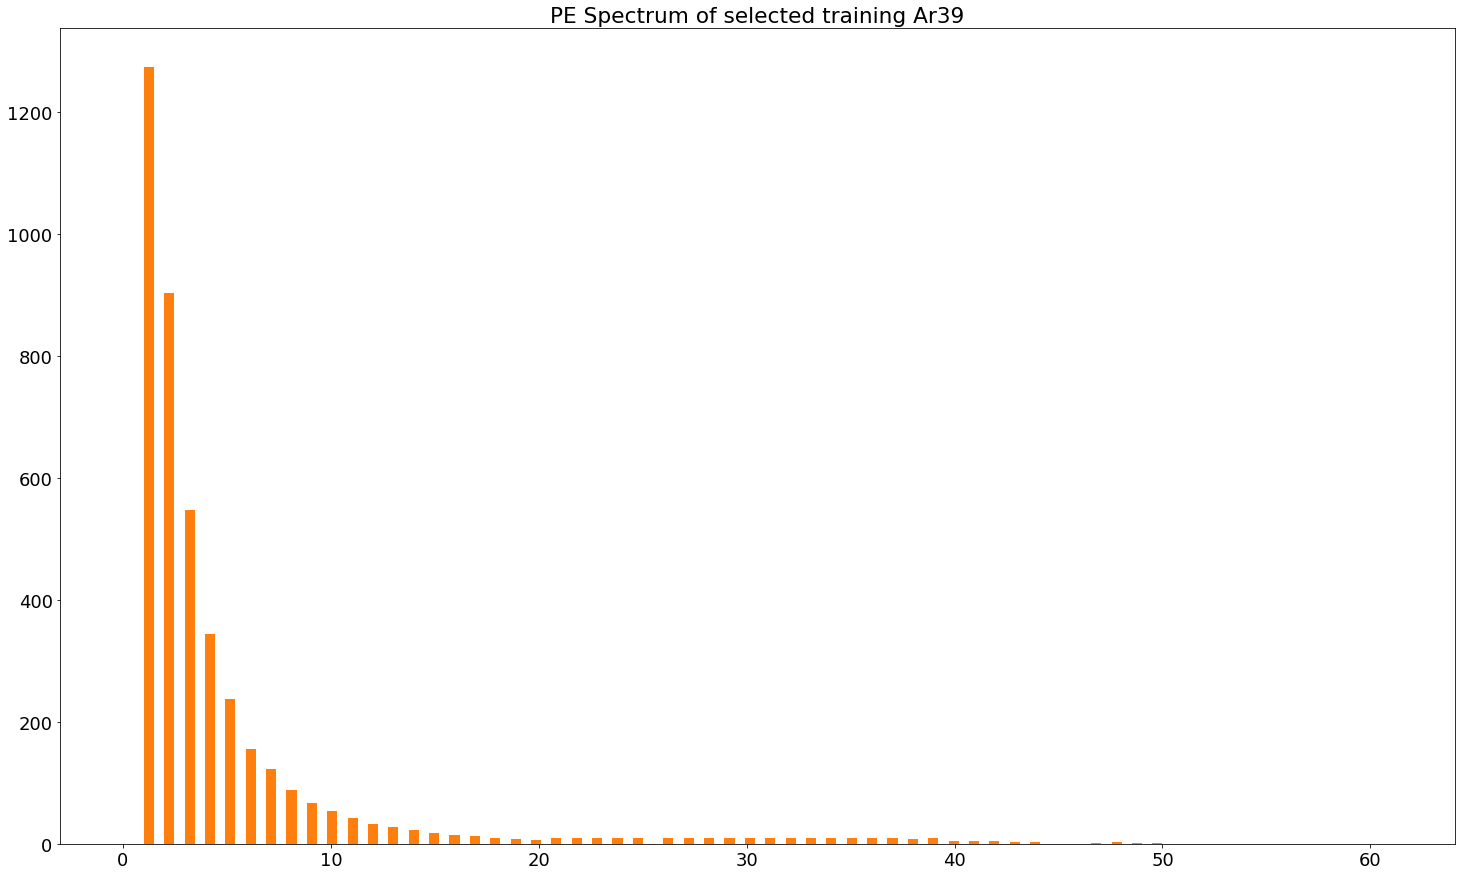

In [65]:
sampled_ar39 = undersample_argon(ar39_train, len(muons_train), augment_from_pe=20, augmentation_nr=10, skip_first_cols=3)
plt.title("PE Spectrum of selected training Ar39")
plt.hist(sampled_ar39.sum(axis=1), bins=100)
plt.show()

In [89]:
# Compute features muon
import time
n_slices = 72

init = time.time()
mu_feat = pd.DataFrame()
mu_feat["PEDetected"] = muons_train.iloc[:, 3:3+n_slices].apply(lambda row: pe_detected(row), axis=1)
mu_feat["NActiveSlices"] = muons_train.iloc[:, 3:3+n_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_feat["MeanNPE"] = muons_train.iloc[:, 3:3+n_slices].apply(lambda row: mean_npe(row), axis=1)
mu_feat["StdNPE"] = muons_train.iloc[:, 3:3+n_slices].apply(lambda row: std_npe(row), axis=1)
mu_feat["SpatialRange"] = muons_train.iloc[:, 3:3+n_slices].apply(lambda row: range_detections(row), axis=1)
mu_feat["SpatialVar"] = muons_train.iloc[:, 3:3+n_slices].apply(lambda row: spatial_var(row), axis=1)
mu_feat["SpatialStd"] = muons_train.iloc[:, 3:3+n_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu features: {:.3f} sec".format(time.time() - init))

init = time.time()
ar39_feat = pd.DataFrame()
ar39_feat["PEDetected"] = sampled_ar39.apply(lambda row: pe_detected(row), axis=1)
ar39_feat["NActiveSlices"] = sampled_ar39.apply(lambda row: nr_active_slices(row), axis=1)
ar39_feat["MeanNPE"] = sampled_ar39.apply(lambda row: mean_npe(row), axis=1)
ar39_feat["StdNPE"] = sampled_ar39.apply(lambda row: std_npe(row), axis=1)
ar39_feat["SpatialRange"] = sampled_ar39.apply(lambda row: range_detections(row), axis=1)
ar39_feat["SpatialVar"] = sampled_ar39.apply(lambda row: spatial_var(row), axis=1)
ar39_feat["SpatialStd"] = sampled_ar39.apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 features: {:.3f} sec".format(time.time() - init))


Compute Mu features: 0.904 sec
Compute Ar39 features: 0.975 sec


In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

init = time.time()

# Prepare data for training
mu_feat["y"] = 1
ar39_feat["y"] = 0
data = pd.concat([mu_feat, ar39_feat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

print("[Info] Tune criterion")
parameters = {'criterion': ['gini', 'entropy']}        

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(max_depth=8, min_samples_leaf=1), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)

# Fit the grid search
clf.fit(X, y)
best_criterion = clf.best_params_["criterion"]
print("Best Criterion: {} => Score: {}".format(best_criterion, clf.best_score_))


print("\n[Info] Tune Depth, Min Samples leaf")
parameters = {'max_depth': [2, 4, 6, 8],
             'min_samples_leaf': [50, 100, 200, 300, 500]}    

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(criterion=best_criterion), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)

# Fit the grid search
clf.fit(X, y)
best_max_depth = clf.best_params_["max_depth"]
best_minleaf = clf.best_params_["min_samples_leaf"]
print("Best Max Depth: {}, Best Min Samples Leaf: {} => Score: {}".format(best_max_depth, best_minleaf, clf.best_score_))

print("\n[Info] Evaluate Best Model - 5-fold CV")
# Use Cross Validation To Evaluate Final Model
clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                            min_samples_leaf=best_minleaf)
clf.fit(X, y)
CV_Result = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("Results: {}".format(CV_Result))
print("Mean Score: {}, Std Dev: {}".format(CV_Result.mean(), CV_Result.std()))

print("Elapsed time {}".format(time.time() - init))


[Info] Tune criterion
Best Criterion: gini => Score: 0.7118034449604217

[Info] Tune Depth, Min Samples leaf
Best Max Depth: 6, Best Min Samples Leaf: 100 => Score: 0.7388385709385881

[Info] Evaluate Best Model - 5-fold CV
Results: [0.73045267 0.71784232 0.77995643 0.77239709 0.6935167 ]
Mean Score: 0.7388330438810847, Std Dev: 0.032808810176381285
Elapsed time 0.8591384887695312


## Features: Importance

Feature: PEDetected, Score: 0.00000
Feature: NActiveSlices, Score: 0.68114
Feature: MeanNPE, Score: 0.00000
Feature: StdNPE, Score: 0.10056
Feature: SpatialRange, Score: 0.04039
Feature: SpatialVar, Score: 0.01433
Feature: SpatialStd, Score: 0.16358


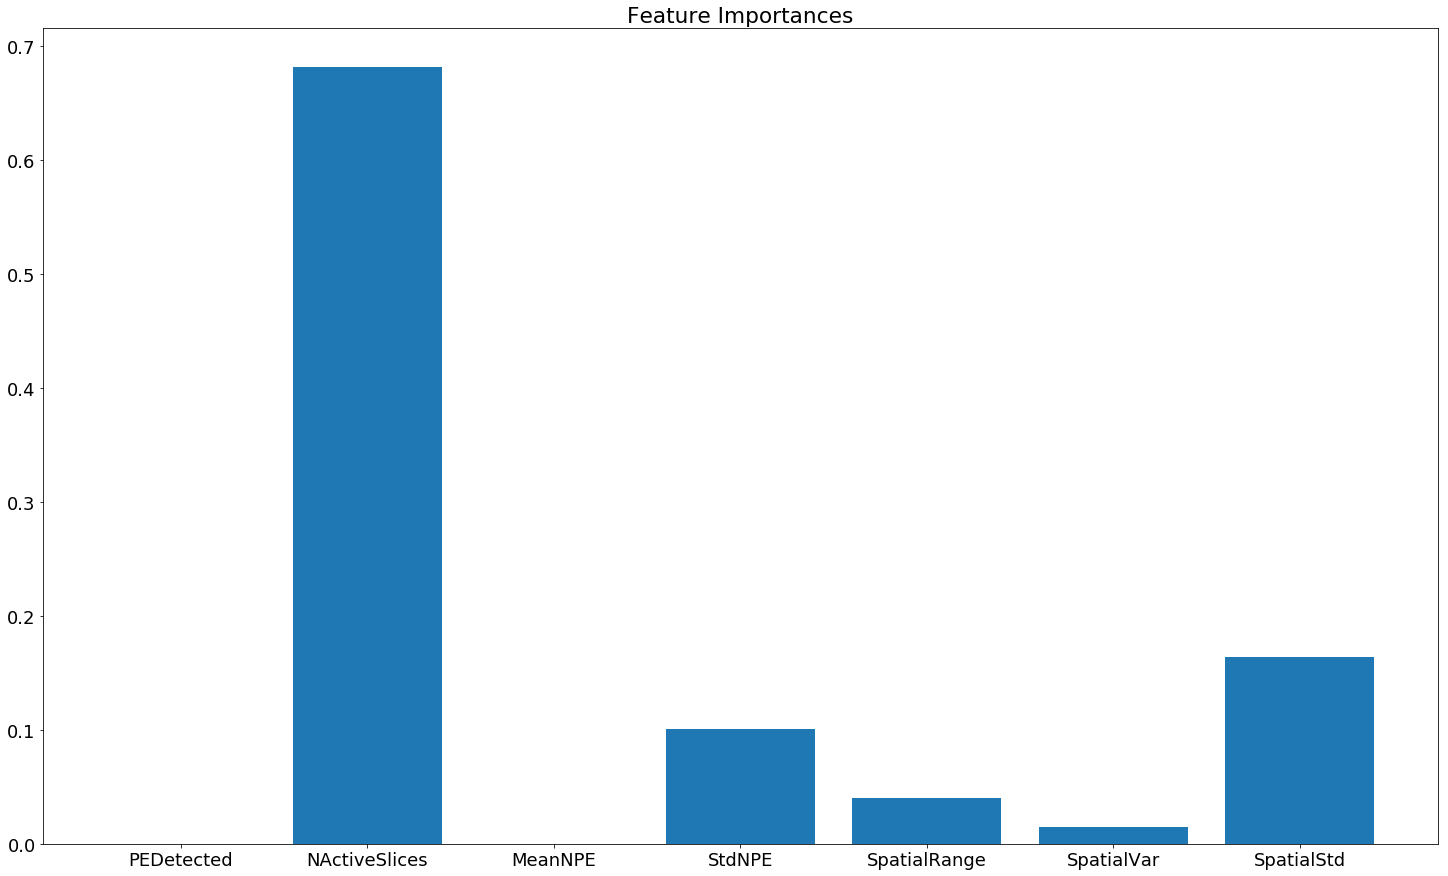

In [101]:
feature_names = ["PEDetected", "NActiveSlices", "MeanNPE", "StdNPE", "SpatialRange", "SpatialVar", "SpatialStd"]
# get importance
importances = clf.feature_importances_
# summarize feature importance
for i, (name, v) in enumerate(zip(feature_names, importances)):
	print('Feature: %s, Score: %.5f' % (name, v))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.xticks(range(0, len(feature_names)), feature_names)
plt.title("Feature Importances")
plt.show()

## Features: Correlation

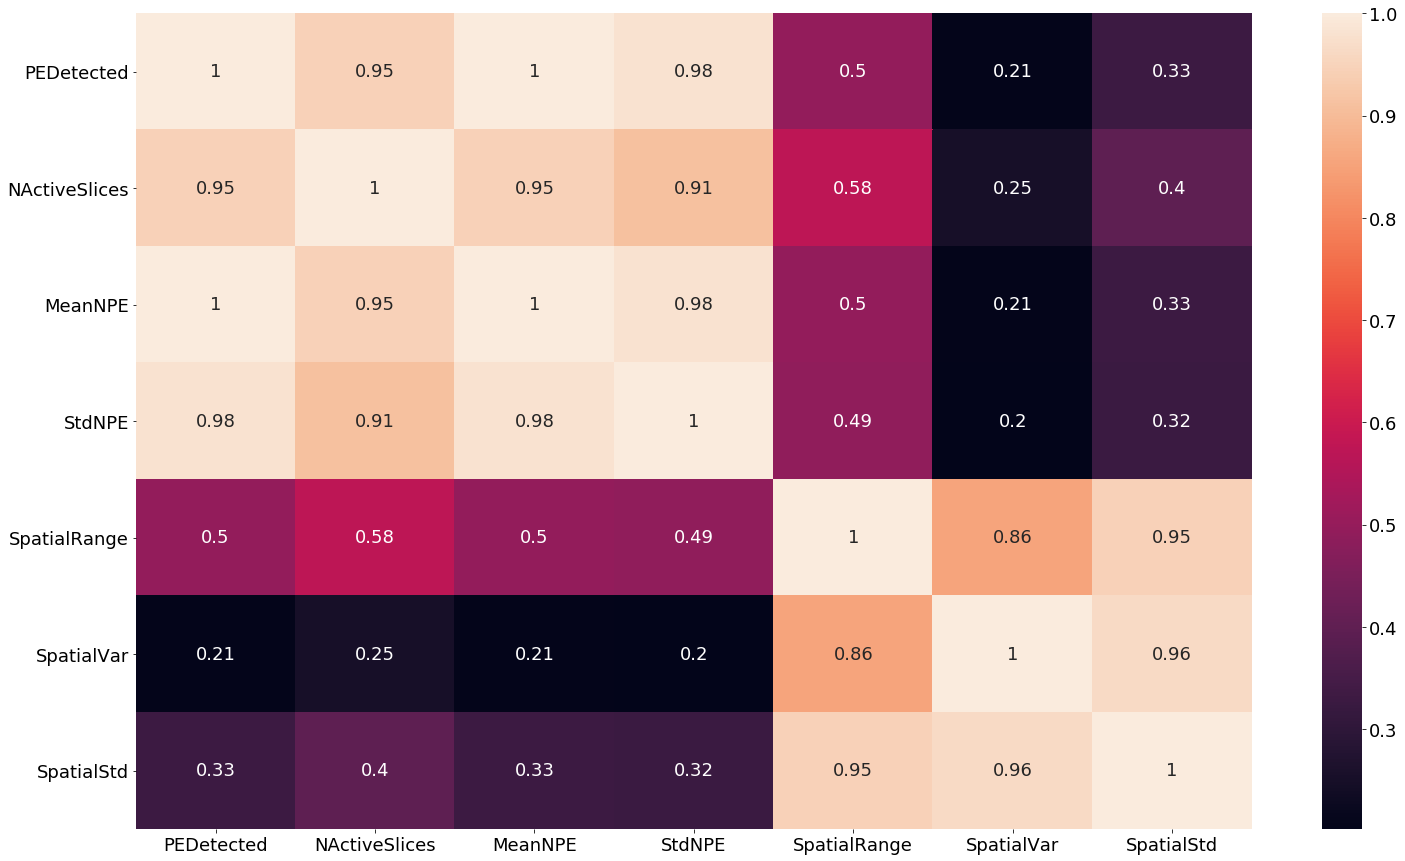

In [104]:
import seaborn as sn

corr_matrix = mu_feat[feature_names].corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

## Evaluate DTree on Test Data

In [105]:
# Prepare data
init = time.time()
mu_test_feat = pd.DataFrame()
mu_test_feat["PEDetected"] = muons_test.iloc[:, 3:3+n_slices].apply(lambda row: pe_detected(row), axis=1)
mu_test_feat["NActiveSlices"] = muons_test.iloc[:, 3:3+n_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_test_feat["MeanNPE"] = muons_test.iloc[:, 3:3+n_slices].apply(lambda row: mean_npe(row), axis=1)
mu_test_feat["StdNPE"] = muons_test.iloc[:, 3:3+n_slices].apply(lambda row: std_npe(row), axis=1)
mu_test_feat["SpatialRange"] = muons_test.iloc[:, 3:3+n_slices].apply(lambda row: range_detections(row), axis=1)
mu_test_feat["SpatialVar"] = muons_test.iloc[:, 3:3+n_slices].apply(lambda row: spatial_var(row), axis=1)
mu_test_feat["SpatialStd"] = muons_test.iloc[:, 3:3+n_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu features: {:.3f} sec".format(time.time() - init))

init = time.time()
ar_test_feat = pd.DataFrame()
ar_test_feat["PEDetected"] = ar39_test.iloc[:, 3:3+n_slices].apply(lambda row: pe_detected(row), axis=1)
ar_test_feat["NActiveSlices"] = ar39_test.iloc[:, 3:3+n_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar_test_feat["MeanNPE"] = ar39_test.iloc[:, 3:3+n_slices].apply(lambda row: mean_npe(row), axis=1)
ar_test_feat["StdNPE"] = ar39_test.iloc[:, 3:3+n_slices].apply(lambda row: std_npe(row), axis=1)
ar_test_feat["SpatialRange"] = ar39_test.iloc[:, 3:3+n_slices].apply(lambda row: range_detections(row), axis=1)
ar_test_feat["SpatialVar"] = ar39_test.iloc[:, 3:3+n_slices].apply(lambda row: spatial_var(row), axis=1)
ar_test_feat["SpatialStd"] = ar39_test.iloc[:, 3:3+n_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu features: {:.3f} sec".format(time.time() - init))


Compute Mu features: 0.152 sec
Compute Mu features: 225.395 sec


In [115]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cv

# Test model
init = time.time()

mu_test_feat["y"] = 1
ar_test_feat["y"] = 0
test_data = pd.concat([mu_test_feat, ar_test_feat], axis=0)
X, y = test_data.iloc[:, :-1], test_data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

y_pred = clf.predict(X)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
tn, fp, fn, tp = cv(y, y_pred).ravel()
tpr, fpr = recall*100, fp/(fp+tn)*100

result_template  = "[Result] {}:\nAccuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"
cm_template  =     "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"


print(result_template.format("Test({} Mu, {} Ar)".format(len(mu_test_feat), len(ar_test_feat)),
                             accuracy, precision, recall, f1))    
print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

[Result] Test(505 Mu, 1000000 Ar):
Accuracy: 0.806, Precision: 0.001, Recall: 0.473, F1: 0.002

[Result] Conf. Matrix: TN: 805740, FP: 194260, FN: 266, TP: 239 | TPR: 47.33%, FPR: 19.43%



## Observations:
1. We consider a very "low energy" scenario of <=53 PE (*because of a restricted Ar39 data for computational reasons*)
1. We achieve a **FPR=19.43%** and a consequent trigger of 480Hz. This is a reduction of a factor 5 of the original 2353Hz rate.
1. Concerning the **efficiency**, it correctly classify the **~50%** of muons in test set. This is quite impressive considering the low energy scenario. **On top of that**, we have to add the fraction of high-energy muons that we can select with NPE.

